In [1]:
%load_ext autoreload
%autoreload 2

In [104]:
import warnings
warnings.filterwarnings("ignore")
import spikeinterface.full as si
import numpy as np
from pathlib import Path
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.peak_localization import localize_peaks
from myfigures_interactive import *
from params import *
from export_files import export_files, recreate_metadata
import os
%matplotlib widget

In [3]:
# Recording path
core_path = Path('D:/Neuropixel_Recordings/')
rec_name = 'Rec_18_08_2022_g0'
rec_path = core_path / rec_name

# Output path
output_path = Path('./test_output/') / rec_name

if not output_path.exists():
    output_path.mkdir()

In [4]:
# Read recording
rec_ap = si.read_spikeglx(rec_path, stream_id='imec0.ap')
rec_preprocessed = si.bandpass_filter(si.common_reference(rec_ap, reference='local', local_radius=(50, 100)), freq_min=300, freq_max=6000)

# Accompanying files
rec_mic = si.read_spikeglx(rec_path, stream_id='nidq')
rec_lf = si.read_spikeglx(rec_path, stream_id='imec0.lf')

In [5]:
recordings = {
    # 'raw':rec_ap,
    'filtered+cmr': rec_preprocessed
                }

In [6]:
# Visualize recording
si.plot_timeseries(recordings, 
                   segment_index=0, 
                   mode='map', # can change to trace
                   order_channel_by_depth=True,
                   clim=(-30, 30),
                   backend='ipywidgets')


AppLayout(children=(VBox(children=(FloatSlider(value=0.0, continuous_update=False, description='time:', layout…

### Compute necessary files for peaks/noise visualization

In [8]:
# Noise
noise_file = output_path / 'noise_levels.npy'
if noise_file.exists():
    noise_levels = np.load(noise_file)
else:
    noise_levels = si.get_noise_levels(rec_preprocessed, return_scaled=False)
    np.save(noise_file, noise_levels)

In [9]:
# Peaks
peaks_file = output_path / 'peaks.npy'
if peaks_file.exists():
    peaks = np.load(peaks_file)
else:
    peaks = detect_peaks(rec_preprocessed, noise_levels=noise_levels, **peak_detection_params, **job_kwargs)
    np.save(peaks_file, peaks)

In [10]:
# Location
location_file = output_path / 'peak_locations.npy'
if location_file.exists():
    peak_locations = np.load(location_file)
else:
    peak_locations = localize_peaks(rec_preprocessed, peaks, **peak_location_params, **job_kwargs)
    np.save(location_file, peak_locations)

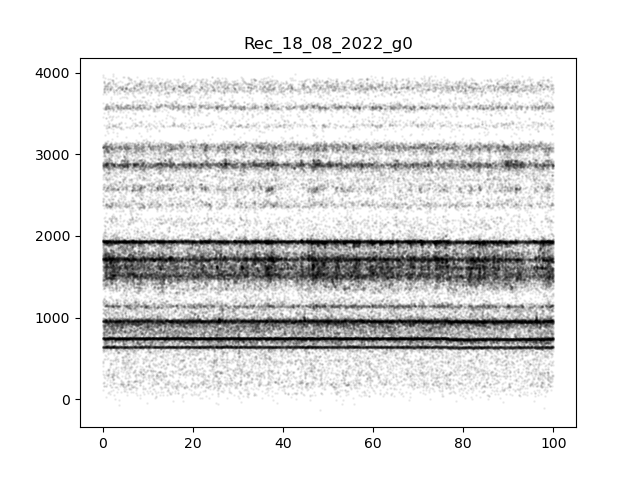

In [15]:
# Visualize
plot_drift(peaks, rec_preprocessed, peak_locations, rec_name, time_range=[0,100])

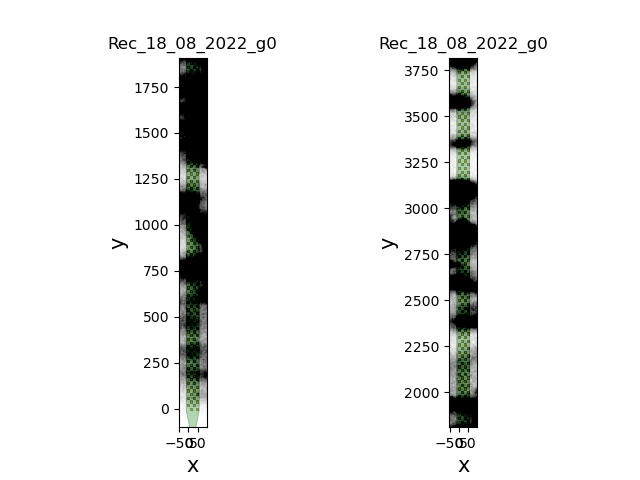

In [17]:
plot_peaks_axis(rec_preprocessed, peak_locations, rec_name, peaks=peaks, time_range=None)

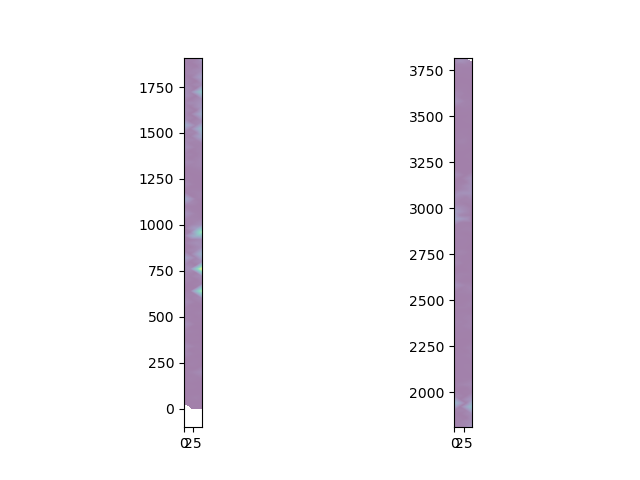

In [18]:
plot_peaks_activity(peaks, rec_preprocessed, peak_locations, rec_name, time_range=None)

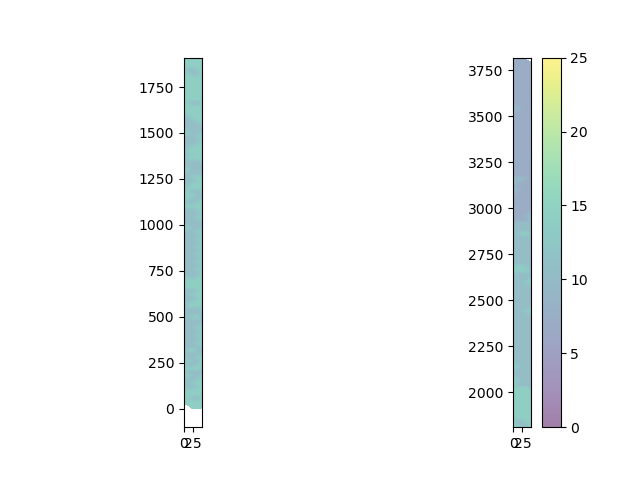

In [25]:
plot_noise(rec_preprocessed, with_contact_color=False, with_interpolated_map=True, time_range=None)

In [223]:
# Save new files
time_range = (10,25)
export_files(rec_ap, rec_lf, rec_mic, rec_path, output_path, time_range)

Done
